In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [11]:
df = pd.read_csv('metadata.csv')
df.head()

,image_filename,label_minerai,durete,eclat,densite
0,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2
1,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2
2,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2
3,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2
4,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2


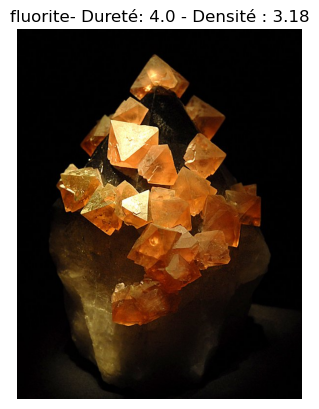

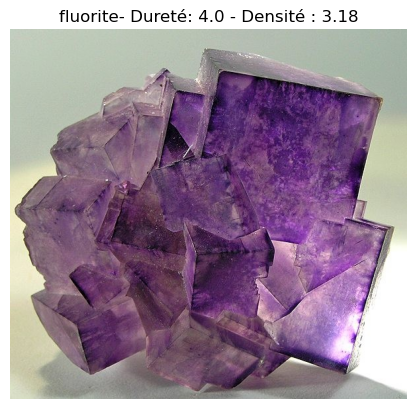

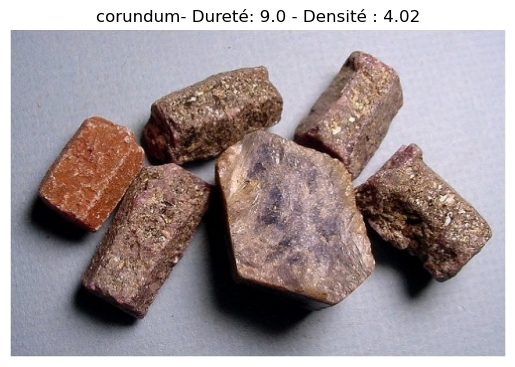

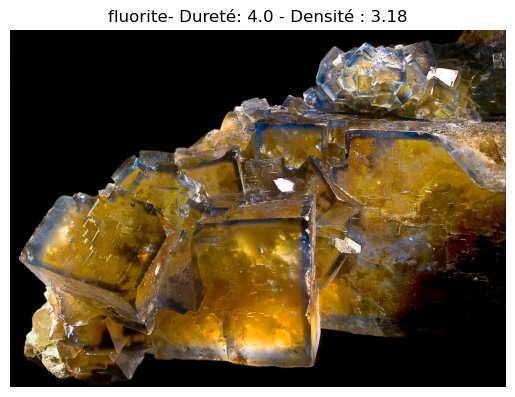

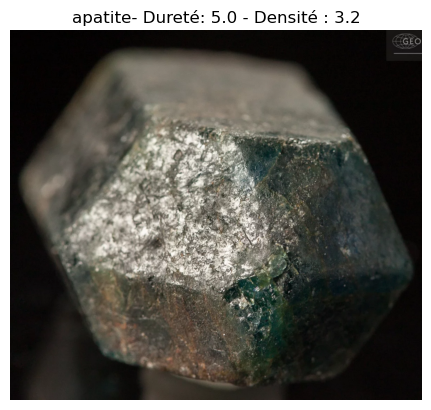

In [6]:
#charger quelques images aleatoire

sample = df.sample(5)

for index, row in sample.iterrows():
    img = mpimg.imread(row['image_filename'])
    plt.imshow(img)
    plt.title(f"{row['label_minerai']}- Dureté: {row['durete']} - Densité : {row['densite']}")
    plt.axis('off')
    plt.show()

In [7]:
df['label_minerai'].unique()

array(['apatite', 'calcite', 'corundum', 'diamond', 'fluorite', 'gypsum',
       'orthoclase', 'quartz', 'talc', 'topaz'], dtype=object)

In [13]:
#Encodage des mineraux
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
df['label'] = encode.fit_transform(df['label_minerai'])

In [14]:
df.head()

,image_filename,label_minerai,durete,eclat,densite,label
0,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2,0
1,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2,0
2,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2,0
3,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2,0
4,C:/Users/ibrad/Desktop/projet mineraux/images\...,apatite,5.0,Vitreux,3.2,0


In [15]:
from sklearn.model_selection import train_test_split

train_df, test_df=train_test_split(df, test_size=0.2, stratify = df['label'], random_state=42)

In [16]:
#pretraitement des images avec tensorflow et keras

import tensorflow as tf

In [37]:
#parametre
IMG_SIZE = (224, 224)

#fonction pour charger et pretraiter une image
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels =3)
    image = tf. image.resize(image, IMG_SIZE)
    image = image/ 255.0 #normalisation
    return image

In [48]:
image_tensors=[]
tabular_inputs = []
labels =[]

for idx, row in df.iterrows():
    img = load_image(row['image_filename']).numpy()
    image_tensors.append(img)

    #Données tabulaires
    tabular = [row['durete'], row['densite']]
    tabular_inputs.append(tabular)

    labels.append(['label'])

#conversion en tensor numpy
X_img = tf.stack(image_tensors)
X_tab = np.array(tabular_inputs)
y= np.array(labels)

In [17]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

In [19]:
#Entree image
image_input = Input(shape =(224, 224,3), name = 'image_input')
base_model = DenseNet121(include_top = False, pooling= 'avg', input_tensor=image_input, weights='imagenet')
base_model.trainable = False #on fige les poigs pour commencer
image_features = base_model.output #vecteur de caracteristiques


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 157s 5us/step  


In [26]:
#Entrée des données tabulaires
tabular_input = Input(shape=(2,), name = 'tabular_input') # 2 features
tabular_dense = Dense(16, activation ='relu')(tabular_input)


In [29]:
# fusion des deux entrée image et données tabulaires
fusion = Concatenate()([image_features, tabular_dense])
x= Dense(64, activation='relu')(fusion)
x =Dense (32, activation ='relu')(x)
output = Dense(10, activation = 'softmax', name='output')(x) # 10 classe de mineraux

In [32]:
#Creation du model
model = Model(inputs=[image_input, tabular_input], outputs =output)

In [33]:
#Compilation
model.compile(optimizer ='adam',
             loss ='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [34]:
#resumé du model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ image_input[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,106,586 (27.11 MB)

 Trainable params: 69,082 (269.85 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [49]:
X_img =np.array(image_tensors)

In [56]:
y = df['label'].astype(np.int32).values

In [57]:
#Separation train/test

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val= train_test_split(
    X_img, X_tab, y, test_size=0.2, stratify=y, random_state=42
)

In [59]:
# phase final entrainement du model
history = model.fit([X_img_train, X_tab_train],     #Double entrée
                   y_train,                         #sortie (classe du minerai)
                   epochs=30,                       #Ajuster en fonction de la puissance de la machine
                   batch_size=32,                    # taille lot
                   validation_data=([X_img_val, X_tab_val], y_val)   #validation pour suivre la performance 
                   )

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5612 - loss: 1.6169 - val_accuracy: 0.3846 - val_loss: 1.9912
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6781 - loss: 1.4713 - val_accuracy: 0.4615 - val_loss: 1.9527
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7566 - loss: 1.3473 - val_accuracy: 0.4615 - val_loss: 1.9578
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7502 - loss: 1.2387 - val_accuracy: 0.4615 - val_loss: 1.9290
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7774 - loss: 1.0930 - val_accuracy: 0.4615 - val_loss: 1.8740
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8287 - loss: 0.9649 - val_accuracy: 0.4615 - val_loss: 1.8106
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8559 - loss: 0.8737 - val_accuracy: 0.4615 - val_loss: 1.7595
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.9279 - loss: 0.7471 - val_accuracy: 0.5385 - val_loss: 1.7302
Epoch 9/30
2/2 ━

In [43]:
print(X_tab[:5])
print(X_tab.dtype)

[[5.  3.2]
 [5.  3.2]
 [5.  3.2]
 [5.  3.2]
 [5.  3.2]]
float64


In [53]:
print(X_img.dtype)

float32


In [54]:
y.dtype

dtype('<U5')